In [28]:
from google.colab import drive

drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [29]:
import sys

sys.path.append("/content/drive/MyDrive/project_work/code") # dodavanje dir kao modula

In [3]:
! pip install ragatouille langchain_openai langchain_core langchain langchain_chroma unstructured

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.7/86.7 kB 5.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 981.5/981.5 kB 41.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.3/67.3 kB 7.5 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.4/50.4 kB 4.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
INFO: pip is looking at multiple versions of multiprocess to determine which version is compatible with other requirements. This could take a while.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.7/41.7 kB 3.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.6/49.6 kB 4.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 400.9/400.9 kB 30.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [30]:
import pandas as pd

data = pd.read_csv("/content/images_all_data.csv") # /content/images_all_data.csv

filtered_data = data.loc[data["question"].isna() == False,:]  # izbrisacemo podatke o onim slicicam automobila + naslove koji su parsirani kao slike

my_data = [(element["question"], element["description"]) for element in filtered_data.to_dict(orient="records")] # ok

full_corpus = [element["description"] for element in data.to_dict(orient="records")] # ok

metadata = [{"metadata":element["path"]} for element in data.to_dict(orient="records")] # ok

In [ ]:
from ragatouille import RAGPretrainedModel, RAGTrainer


trainer = RAGTrainer(model_name="images-fine-tune-colbert-all-3",
                     pretrained_model_name="colbert-ir/colbertv2.0")

trainer.prepare_training_data(raw_data=my_data,
                            data_out_path="./data/",
                            all_documents = full_corpus)

trainer.train(batch_size = 2,
              dim=128, # onda sam povecao dimenzionalnost 1 vektorske reprezentacije, jer su oba imala skor 'score': 16.609375
              # kako ColBERT pravi embedding po uzoru na BERT, to znaci da je maximalna velicina embeddinga queryja i dokumenta 768.
              doc_maxlen=512, # ja se nadam da neki dokument nema vise od 512 tokena,
              use_relu=False) # on vec ovde u treningu za ovaj model bilduje index, tako da se moze samo cuvati nesmetano index i to bez modela


Loading Hard Negative SimpleMiner dense embedding model BAAI/bge-small-en-v1.5...
Building hard negative index for 221 documents...
All documents embedded, now adding to index...
save_index set to False, skipping saving hard negative index
Hard negative index generated
#> Starting...


KeyboardInterrupt: 

In [ ]:
model_path = "/content/.ragatouille/colbert/none/2024-09/30/14.26.51/checkpoints/colbert/"

# "/content/.ragatouille/colbert/none/2024-09/29/15.37.37/checkpoints/colbert/"

RAG = RAGPretrainedModel.from_pretrained(model_path)

RAG.index(
    collection = full_corpus,
    index_name = "images-fine-tuned-colbert-all-data-3",
    max_document_length=512,
    split_documents = False,
    document_metadatas = metadata
)

---- WARNING! You are using PLAID with an experimental replacement for FAISS for greater compatibility ----
This is a behaviour change from RAGatouille 0.8.0 onwards.
This works fine for most users and smallish datasets, but can be considerably slower than FAISS and could cause worse results in some situations.
If you're confident with FAISS working on your machine, pass use_faiss=True to revert to the FAISS-using behaviour.
--------------------


[Sep 30, 14:30:21] #> Creating directory .ragatouille/colbert/indexes/images-fine-tuned-colbert-all-data-3 




/usr/local/lib/python3.10/dist-packages/colbert/utils/amp.py:12: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  self.scaler = torch.cuda.amp.GradScaler()


[Sep 30, 14:30:21] [0] 		 #> Encoding 221 passages..


/usr/local/lib/python3.10/dist-packages/colbert/utils/amp.py:15: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  return torch.cuda.amp.autocast() if self.activated else NullContextManager()


[Sep 30, 14:30:23] [0] 		 avg_doclen_est = 223.65158081054688 	 len(local_sample) = 221
[Sep 30, 14:30:23] [0] 		 Creating 2,048 partitions.
[Sep 30, 14:30:23] [0] 		 *Estimated* 49,426 embeddings.
[Sep 30, 14:30:23] [0] 		 #> Saving the indexing plan to .ragatouille/colbert/indexes/images-fine-tuned-colbert-all-data-3/plan.json ..


/usr/local/lib/python3.10/dist-packages/colbert/indexing/collection_indexer.py:256: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  sub_sample = torch.load(sub_sample_path)


used 20 iterations (0.7207s) to cluster 46956 items into 2048 clusters
[Sep 30, 14:30:24] Loading decompress_residuals_cpp extension (set COLBERT_LOAD_TORCH_EXTENSION_VERBOSE=True for more info)...


/usr/local/lib/python3.10/dist-packages/torch/utils/cpp_extension.py:1965: UserWarning: TORCH_CUDA_ARCH_LIST is not set, all archs for visible cards are included for compilation. 
If this is not desired, please set os.environ['TORCH_CUDA_ARCH_LIST'].
  warnings.warn(


[Sep 30, 14:30:24] Loading packbits_cpp extension (set COLBERT_LOAD_TORCH_EXTENSION_VERBOSE=True for more info)...


/usr/local/lib/python3.10/dist-packages/torch/utils/cpp_extension.py:1965: UserWarning: TORCH_CUDA_ARCH_LIST is not set, all archs for visible cards are included for compilation. 
If this is not desired, please set os.environ['TORCH_CUDA_ARCH_LIST'].
  warnings.warn(


[0.029, 0.028, 0.028, 0.028, 0.027, 0.032, 0.027, 0.03, 0.027, 0.029, 0.028, 0.029, 0.028, 0.031, 0.028, 0.029, 0.027, 0.029, 0.028, 0.027, 0.028, 0.028, 0.028, 0.029, 0.028, 0.031, 0.03, 0.031, 0.028, 0.031, 0.03, 0.029, 0.029, 0.026, 0.032, 0.028, 0.03, 0.03, 0.03, 0.033, 0.029, 0.031, 0.028, 0.029, 0.027, 0.027, 0.028, 0.032, 0.029, 0.03, 0.03, 0.029, 0.026, 0.029, 0.031, 0.031, 0.031, 0.029, 0.031, 0.029, 0.028, 0.027, 0.027, 0.031, 0.031, 0.032, 0.03, 0.029, 0.028, 0.028, 0.03, 0.03, 0.027, 0.029, 0.033, 0.029, 0.032, 0.029, 0.029, 0.033, 0.03, 0.028, 0.029, 0.033, 0.025, 0.031, 0.029, 0.027, 0.028, 0.029, 0.03, 0.029, 0.031, 0.03, 0.029, 0.028, 0.033, 0.029, 0.031, 0.03, 0.028, 0.029, 0.026, 0.03, 0.03, 0.028, 0.027, 0.03, 0.031, 0.029, 0.029, 0.03, 0.031, 0.028, 0.028, 0.029, 0.028, 0.03, 0.03, 0.028, 0.029, 0.03, 0.031, 0.032, 0.03, 0.029, 0.029, 0.032]


/usr/local/lib/python3.10/dist-packages/colbert/indexing/codecs/residual.py:141: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  centroids = torch.load(centroids_path, map_loc

[Sep 30, 14:30:25] [0] 		 #> Encoding 221 passages..


/usr/local/lib/python3.10/dist-packages/colbert/utils/amp.py:15: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  return torch.cuda.amp.autocast() if self.activated else NullContextManager()
1it [00:01,  1.78s/it]
  0%|          | 0/1 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/colbert/indexing/codecs/residual_embeddings.py:86: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they 

[Sep 30, 14:30:26] #> Optimizing IVF to store map from centroids to list of pids..
[Sep 30, 14:30:26] #> Building the emb2pid mapping..
[Sep 30, 14:30:26] len(emb2pid) = 49427



100%|██████████| 2048/2048 [00:00<00:00, 60720.41it/s]

[Sep 30, 14:30:26] #> Saved optimized IVF to .ragatouille/colbert/indexes/images-fine-tuned-colbert-all-data-3/ivf.pid.pt
Done indexing!


'.ragatouille/colbert/indexes/images-fine-tuned-colbert-all-data-3'

In [ ]:
RAG.search("a rough thin-plate spline fit to the Income data")

# "Graph of Poisson regression model fit to the Bikeshare dataset showing the monthly and hourly coefficients?" - hoce 177-62

# "Graph of Poisson regression model fit to the Bikeshare dataset showing the correlation between hour and log of number of bikers?" - 178-63 HOCE

# Graph of smooth thin-plate spline fit to the Income data - RADI

# "Graph of rough smooth thin-plate spline fit to the Income data" - previse ambiciozno, lol

# Graph of trade off between flexibility and interpretability throughout different statistical learning methods - radi

# clustering data set into 3 groups - top, ovo je slika na kojoj ne pise apsolutno nista

# show me three estimates of f: linear regression, and two smoothing spline fits

# "show me graph that explains squared bias, variance, MSE for the three datasets"

# bayes decision boundary for dataset consists of 100 observations separated into two groups" - drugo mesto

# "KNN decision boundary and Bayes decision boundary for dataset consists of 100 observations separated into two groups" - radi

#  "show me the least squares regression line plane in a three-dimensional setting, with two predictors and one response" - radi

# - show me Local regression illustrated on some simulated data- radi

# show me illustration of gradient descent for one-dimensional theta - drugi dokument slika

# show me evolution of training and validation errors for neural network for MNIST dataset - hoce

# show me neural network with dropout in the input and hidden layer - 3. slika

# Squared bias, variance, and test mean squared error for the ridge regression predictions on a simulated data set - radi

# show me figure of contours of the error and constraint functions for the lasso and ridge regression - radi

[{'content': 'The image is a 3D surface plot that visualizes the relationship between three variables: Income, Years of Education, and Seniority. \n\n- The X-axis represents "Years of Education."\n- The Y-axis represents "Seniority."\n- The Z-axis represents "Income."\n\nThe surface is a grid mesh that is colored yellow and is overlaid with a blue net. This mesh surface appears to be undulating, indicating variations in income based on the different combinations of years of education and seniority.\n\nAdditionally, there are red dots scattered on and around the surface. These dots likely represent individual data points, showing specific instances of income levels for given years of education and seniority.\n\nThe overall trend suggests that both years of education and seniority have an impact on income, with income generally increasing as both factors increase. However, the exact nature of this relationship appears to be complex, as indicated by the non-linear and uneven surface.',
  

In [ ]:
# cuvanje modela

%cp -r /content/.ragatouille/colbert/none/2024-09/30/05.56.23/checkpoints/colbert /content/drive/MyDrive/ImagesColbertCheckpoints/ # sve sto se tice modela za trening embeddinga za opise slika

In [ ]:
# cuvanje indexa

%cp -r /content/.ragatouille/colbert/indexes/images-fine-tuned-colbert-all-data/ /content/drive/MyDrive/images-fine-tuned-colbert-all-data # index za slike

In [ ]:
%cd /content

/content


In [4]:
# ucitavanje indexa from scratch

import ragatouille
from ragatouille import RAGPretrainedModel, RAGTrainer

path_to_model_drive = '/content/drive/MyDrive/ImagesColbertCheckpoints/'

RAGImagesDrive = RAGPretrainedModel.from_pretrained(path_to_model_drive)


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/colbert/utils/amp.py:12: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  self.scaler = torch.cuda.amp.GradScaler()


In [5]:
# napraviti direktorijum za checkpoints modela za index koji je vec postojao a sacuvan je na drive-u

%mkdir -p /content/.ragatouille/colbert/none/2024-09/30/05.56.23/checkpoints/colbert

%cp -r /content/drive/MyDrive/ImagesColbertCheckpoints/* /content/.ragatouille/colbert/none/2024-09/30/05.56.23/checkpoints/colbert

In [6]:
%cd /content/.ragatouille/colbert/none/2024-09/30/05.56.23/checkpoints/colbert
!ls -la

/content/.ragatouille/colbert/none/2024-09/30/05.56.23/checkpoints/colbert
total 429020
drwxr-xr-x 2 root root      4096 Oct  1 05:57 .
drwxr-xr-x 3 root root      4096 Oct  1 05:57 ..
-rw------- 1 root root      1674 Oct  1 05:57 artifact.metadata
-rw------- 1 root root       664 Oct  1 05:57 config.json
-rw------- 1 root root 438345624 Oct  1 05:57 model.safetensors
-rw------- 1 root root       695 Oct  1 05:57 special_tokens_map.json
-rw------- 1 root root      1190 Oct  1 05:57 tokenizer_config.json
-rw------- 1 root root    711396 Oct  1 05:57 tokenizer.json
-rw------- 1 root root    231508 Oct  1 05:57 vocab.txt


In [7]:
%cd /content

/content


In [8]:
# ucitavanje indexa koji sam sacuvao na dive-u

index_path = "/content/drive/MyDrive/images-fine-tuned-colbert-all-data"

indexImagesDrive = RAGImagesDrive.from_index(index_path)

In [ ]:
results = indexImagesDrive.search("a smooth thin-plate spline fit to the Income data")

In [ ]:
results # radi sve ok, to bi bio povratak slike iz baze podataka, koja ima kljuc figures/figure-255-88.jpg

[{'content': 'The image is a 3D surface plot that visualizes the relationship between three variables: Income, Years of Education, and Seniority. \n\n- The X-axis represents "Years of Education."\n- The Y-axis represents "Seniority."\n- The Z-axis represents "Income."\n\nThe surface is a grid mesh that is colored yellow and is overlaid with a blue net. This mesh surface appears to be undulating, indicating variations in income based on the different combinations of years of education and seniority.\n\nAdditionally, there are red dots scattered on and around the surface. These dots likely represent individual data points, showing specific instances of income levels for given years of education and seniority.\n\nThe overall trend suggests that both years of education and seniority have an impact on income, with income generally increasing as both factors increase. However, the exact nature of this relationship appears to be complex, as indicated by the non-linear and uneven surface.',
  

In [ ]:
%pip install google-cloud-language>=2.9.1

In [9]:
from google.colab import auth
auth.authenticate_user()

# povezivanje google clouda sa google colabom
from google.cloud import storage

/usr/local/lib/python3.10/dist-packages/colbert/utils/amp.py:15: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  return torch.cuda.amp.autocast() if self.activated else NullContextManager()


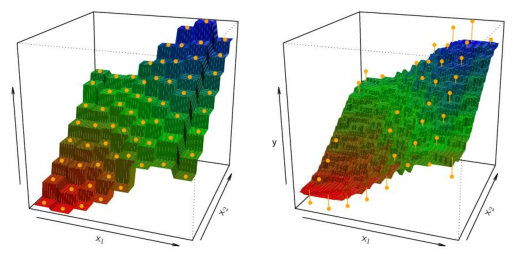

In [56]:
from PIL import Image
import io
import matplotlib.pyplot as plt


def get_image(query):
  results = indexImagesDrive.search(query)
  blob_name = results[0]["document_metadata"]["metadata"].split("figures/")[1]
  storage_client = storage.Client()
  bucket = storage_client.bucket("images_data_bucket")
  blob = bucket.blob(blob_name)
  image_data = blob.download_as_bytes()
  image = Image.open(io.BytesIO(image_data))
  plt.imshow(image)
  plt.axis("off")
  plt.show()

query1 = "show me figure of contours of the error and constraint functions for the lasso and ridge regression"
query2 = "Graph of smooth thin-plate spline fit to the Income data"
query3 = "KNN decision boundary and Bayes decision boundary for dataset consists of 100 observations separated into two groups"
query4 = "Graph of Poisson regression model fit to the Bikeshare dataset showing the monthly and hourly coefficients?"
query5 = "Boxplots of the test error rates for each of the linear scenarios described in the main text"
query6 = "Validation error estimates for a ten different splits of the observations into a training set and a validation set."
query7 = "display me LOOCV on the set of n data points" # 7 i 9 su obrnuti...
query9 = "schematic display of the validation set approach, where set of n observations is randomly split"
query8 = "Nine CV error curves for Auto data set as result of 10-fold CV" # ok
query10 = "True and estimated test MSE for LOOCV and 10-fold CV estimates" # nece
query11 = "linear, quadratic, cubic and quartic logistic regression fits on two-dimensional classification data and Bayes decision boundary"
query12 = "100 simulated returns for investments X and Y." # hoce
query13 = "A histogram of the estimates of α obtained by generating 1,000 simulated data sets from the true population" # hoce
query14 = "A graphical illustration of the bootstrap approach" # ok
query15 = "Show me for each posiible model subset of ten predictors in the Credit dataset and display RSS abd R^2" # hoce
query16 = "Show me Cp, BIC and adjusted R^2 for the best models of each size in the Credit dataset." # ok
query17 = "Show me square root of BIC and Validation Set and Cross Validation set Error for the best models of size of d predictors in the Credit dataset." # ok
query18 = "Display the standardized ridge regression coefficients for the Credit data set and its correlations to the lambda, and beta"
query19 = "Display the standardized lasso regression coefficients for the Credit data set and its correlations to the lambda, and beta" # HOCE, ali prethodni nece
query20 = "Show me plots of squared bias, variance and test MSE for the lasso when only two predictors are related to the response." # nece
query21 = "Show me Cross-validation errors that result from applying ridge regression to the Credit data set with various values of λ." # ok
query22 = "Display to me PCR standardized coefcient estimates on the Credit data set for diferent values of M" # nece
query23 = "First PCR direction and first PLS direction for the advertising data" # ok
query24 = "a rough thin-plate spline fit to the Income data" # adi i smooth. sledeci korak- reranking za neke slicne primere gde nam treba neki 10. dokument
query25 = "Clustering data set of three groups containing two graphs" # da nisam napisao containing 2 graphs ne bi hteo


query26 = "Show me comparison of the three estimates of f: regression and two smoothing spline fits " # hoce
query27 = "Show me figure of the three estimates of f: regression and two smoothing spline fits where true f is much closer to linear" # i ovo ce lepo prikazati iako ne postoje reci smoothing spline fits, ni regression ... ok . ovo je slika koja nema nista na sebi od opisa nego se prepoznaje preko pitanja
query28 = "Show me figure of the three estimates of f: linear regression and two smoothing spline fits where f is far from linear" # ovo nece

query29 = "Show me squared bias, variance and MSE for three datasets" # ok, hoce
query30 ="Data set of 100 observations of two groups with Bayes decision boundary."

query31 = "KNN decision boundary and Bayes decision boundary for K = 10"
query32 = "KNN boundaries and Bayes decision boundaries using K = 1 and K = 100 on the data" # ovaj nece...
query33 = "KNN decision boundaries for six blue and six orange observations using K = 3" # nece

query34 = "Show me figure of KNN training error rate and test error rate with Bayes error rate" # hoce

query35 = "The least squares fit for the regression of the TV and sales on the Advertising data" # hoce i ovo
query36 = "three-dimensional plot of the RRS, beta1 and beta2 on the Advertising data" # nece

query37 = "Show me the least squares regression line in the three-dimensional setting" # ok

query38 = "Show me residuals plot for the Advertising data using TV and radio as predictors" # ok

query39 = "Plots of f-hat(X) using KNN regression on a two-dimensional data set with 64 observations" # hoce kad napises f-hat(X)

get_image(query39)


In [59]:
import shutil

destination = "/content/drive/MyDrive/project_work/code/images retrieval/Images_Retrieval.ipynb"

shutil.copy("/content/drive/MyDrive/Colab Notebooks/Images_Retrieval.ipynb", destination)

'/content/drive/MyDrive/project_work/code/images retrieval/Images_Retrieval.ipynb'

In [72]:
destination = "/content/drive/MyDrive/project_work/code/formulas retrieval/Formulas_Retrieval.ipynb"

shutil.copy("/content/drive/MyDrive/Colab Notebooks/Formulas_Index.ipynb", destination)

'/content/drive/MyDrive/project_work/code/formulas retrieval/Formulas_Retrieval.ipynb'

Pokusaj da kreiramo indeks

In [60]:
sys.path.append("/content/drive/MyDrive/project_work/code/images retrieval")

In [64]:
from images_retrieval import load_index

index_test = load_index()

In [68]:
results = index_test.search("Plots of f-hat(X) using KNN regression on a two-dimensional data set with 64 observations")